In [1]:
print('kernel started successfully')

kernel started successfully


In [2]:
from os import listdir
from torch import load
from matplotlib import pyplot as plt
import numpy as np

# Load all results from a test

In [3]:
root = 'TrainingSchedulerFiles/results/'

test_template_folder = 'targeted_vs_random_sampling_convergence/'
metric_names = []
non_metric_names = ['iter', 'epoch', 'lr', 'training_loss', 'testing_loss', 'test_accuracy']

results = dict()
for dataset in listdir(root + test_template_folder):
    dataset_folder = root + test_template_folder + f'{dataset}/'
    results[dataset] = dict()
    for model_name in listdir(dataset_folder):
        results[dataset][model_name] = dict()
        model_folder = dataset_folder + f'{model_name}/'
        test_files = listdir(model_folder)

        for filename in test_files:
            if '.results' in filename:
                results[dataset][model_name][int(filename.strip('.results').strip('_'))] = load(model_folder + f'/{filename}')

                for metric_name in results[dataset][model_name][1]['metrics'].keys():
                    if metric_name not in metric_names and metric_name not in non_metric_names:
                        metric_names += [metric_name]

In [4]:
# from random import choices
from numpy.random import default_rng
import random
import scipy.stats as st

def expected_max_over_n_samples(input_: list[float], subsample_size: int, statistic_function, c_interval_p: float = .95,
                                n_subsamples_each: int = 10000) -> (float, float, float):
    """
    Bootstraps with fixed samples sizes to get the expected output of statistic_function on input_.
    Returns the mean and the lower and upper values of the confidence interval requested.
    """
    rng = default_rng(random.randint(2**5, 2**8))
    sub_stats = [statistic_function(rng.choice(input_, subsample_size)) for _ in range(n_subsamples_each)]
    mean = np.mean(sub_stats)
    lower, upper = st.t.interval(alpha=c_interval_p, df=len(sub_stats)-1, loc=mean, scale=np.std(sub_stats))

    return mean, lower, upper

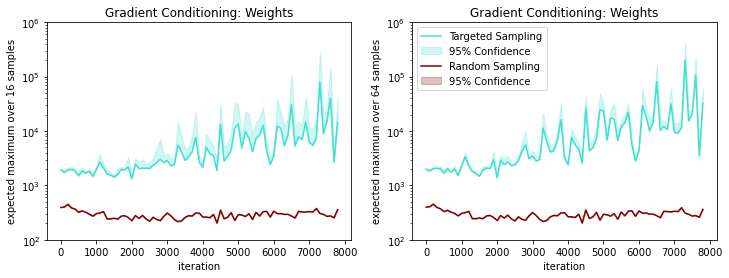

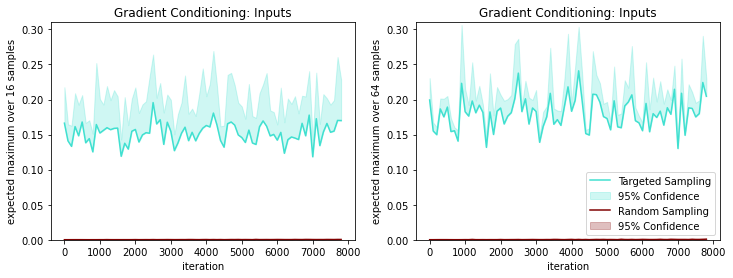

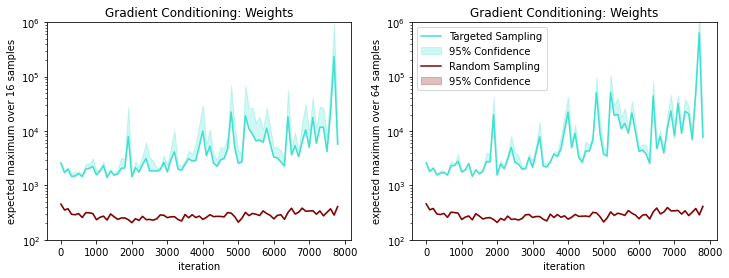

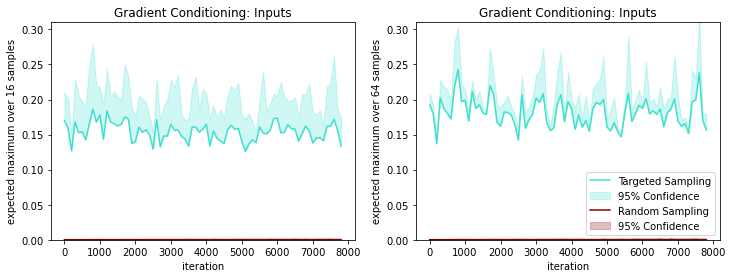

In [6]:
# only one dataset is used here
subsample_sizes = [16, 64]
c_interval_p = .9
n_subsamples = 1000

for model_name, metric_data in results['cifar10'].items():
    for test_num, results_i in metric_data.items():
        for metric_name in ['conditioning_w', 'conditioning_x']:
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))
            n_iters_completed = len(results_i['metrics'][metric_name])

            t_means = np.zeros((len(subsample_sizes), n_iters_completed))
            t_lower_c = np.zeros((len(subsample_sizes), n_iters_completed))
            t_upper_c = np.zeros((len(subsample_sizes), n_iters_completed))
            r_means = np.zeros((len(subsample_sizes), n_iters_completed))
            r_lower_c = np.zeros((len(subsample_sizes), n_iters_completed))
            r_upper_c = np.zeros((len(subsample_sizes), n_iters_completed))

            for i, n in enumerate(subsample_sizes):
                random.seed(124124)
                for j in range(len(results_i['metrics']['iter'])):
                    if metric_name == 'conditioning_x':
                        idx0 = 1
                        idx1 = 0
                    else:
                        idx0 = 0
                        idx1 = 1
                    t_means[i, j], t_lower_c[i, j], t_upper_c[i, j] = expected_max_over_n_samples(results_i['metrics'][metric_name][j][idx0]['100%_0'],
                                                                                                  n, np.max, c_interval_p, n_subsamples)
                    r_means[i, j], r_lower_c[i, j], r_upper_c[i, j] = expected_max_over_n_samples(results_i['metrics'][metric_name][j][idx1]['100%_0'],
                                                                                                  n, np.max, c_interval_p, n_subsamples)

            x = results_i['metrics']['iter']
            for i, n in enumerate(subsample_sizes):
                ax[i].plot(x, t_means[i], color='turquoise', label='Targeted Sampling')
                ax[i].fill_between(x, t_means[i], t_upper_c[i], color='turquoise', label=f'{95}% Confidence', alpha=.25)
                ax[i].plot(x, r_means[i], color='maroon', label='Random Sampling')
                ax[i].fill_between(x, r_means[i], r_upper_c[i], color='maroon', label=f'{95}% Confidence', alpha=.25)
                ax[i].set_ylabel(f'expected maximum over {n} samples')
                ax[i].set_xlabel('iteration')
                if metric_name == 'conditioning_w':
                    ax[i].set_title(f'Gradient Conditioning: Weights')
                    ax[i].set_yscale('log')
                    ax[i].set_ylim(10**2, 10**6)
                else:
                    ax[i].set_title(f'Gradient Conditioning: Inputs')
                    ax[i].set_ylim(0, .31)
            if metric_name == 'conditioning_w':
                ax[1].legend(loc='upper left')
            else:
                ax[1].legend(loc='lower right')
            plt.savefig(f'plots/targeted_vs_random_sampling/{model_name}_{test_num}_{metric_name}.pdf', bbox_inches='tight', dpi=3000)
            plt.show()
                ax[i].plot(x, t_means[i], color='turquoise', label='Targeted Sampling')
                ax[i].fill_between(x, t_means[i], t_upper_c[i], color='turquoise', label=f'{95}% Confidence', alpha=.25)
                ax[i].plot(x, r_means[i], color='maroon', label='Random Sampling')
                ax[i].fill_between(x, r_means[i], r_upper_c[i], color='maroon', label=f'{95}% Confidence', alpha=.25)
                ax[i].set_ylabel(f'expected maximum over {n} samples')
                ax[i].set_xlabel('iteration')
                if metric_name == 'conditioning_w':
                    ax[i].set_title(f'Gradient Conditioning: Weights')
                    ax[i].set_yscale('log')
                    ax[i].set_ylim(10**2, 10**6)
                else:
                    ax[i].set_title(f'Gradient Conditioning: Inputs')
                    ax[i].set_ylim(-.01, .31)
            if metric_name == 'conditioning_w':
                ax[1].legend(loc='upper left')
            else:
                ax[1].legend(loc='lower right')
            plt.savefig(f'plots/targeted_vs_random_sampling/{model_name}_{test_num}_{metric_name}.pdf', bbox_inches='tight', dpi=3000)
            plt.show()

                # plt.plot(x, results_i['metrics']['testing_loss'])
                # plt.show()

    break